In [2]:
import warnings
warnings.filterwarnings("ignore")

import io
import os
import os.path
import re
import spacy
import time
import pickle

import numpy as np
import pandas as pd
from pprint import pprint

import gensim
from gensim.models import Phrases, LdaModel, CoherenceModel
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess
from gensim.test.utils import datapath

import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
os.environ.update({'MALLET_HOME':r'C:/mallet/mallet-2.0.8/'})
mallet_path = 'C:\\mallet\\mallet-2.0.8\\bin\\mallet'
pd.options.display.max_columns = 100

C:\Users\f.braulio\Anaconda3\envs\ugpn-covid-emotions\lib\site-packages\sklearn\linear_model\_least_angle.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
C:\Users\f.braulio\Anaconda3\envs\ugpn-covid-emotions\lib\site-packages\sklearn\linear_model\_least_angle.py:164: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release

In [3]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def compute_coherence_values(id2word, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    chunksize = 2000
    passes = 20
    iterations = 400
    eval_every = None  # Don't evaluate model perplexity, takes too much time.
    for num_topics in range(start, limit, step):
        ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word, random_seed=50)
        model_list.append(ldamallet)
        coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model_ldamallet.get_coherence())

    return model_list, coherence_values

def loop_compute_coherence_values(id2word, corpus, texts, limit, mallet_path, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word, random_seed=50)
        model_list.append(ldamallet)
        coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model_ldamallet.get_coherence())
        print(num_topics)
    return model_list, coherence_values

# Load and process News Tweets

In [4]:
# Load lookup tables
media_list = pd.read_csv('./../data/external/MediaList.csv', sep=";")
news_accounts = pd.read_parquet('./../data/raw/news_accounts.parquet')
emotions = ['anger', 'sadness', 'optimism', 'joy']

# Process lookup tables
news_accounts = news_accounts.merge(media_list)
news_accounts['userId'] = news_accounts.userId.astype('float64')

# Load news tweets
news_tweets = pd.read_parquet('./../data/raw/news_tweets_with_em_scores.parquet')

# Include country information and filter valid news accountsw
news_tweets = news_tweets.merge(news_accounts[['userId','country']])
news_tweets = news_tweets[~news_tweets[emotions].isnull().any(axis=1)]
news_tweets = news_tweets.sort_values('date').drop_duplicates('conversationId', keep='first')
news_tweets = news_tweets[news_tweets.lang=='en']
print('Number of valid news tweets:', news_tweets.shape[0])

# Generate content file
news_tweets = news_tweets.reset_index(drop=True)
data = list(news_tweets.content)
print("Just collected", len(data), "tweets.")
del media_list, news_accounts

Number of valid news tweets: 1678217
Just collected 1678217 tweets.


In [4]:
# Clean data
start = time.time()
nlp = spacy.load("en_core_web_sm")
docs = []
for doc in nlp.pipe(data, disable=["tok2vec", "tagger", "parser", "attribute_ruler"]):
    docs.append([
        re.sub(r'[^\w\s]|[0-9]|[_]', '', token.lemma_.lower()) for token in doc
        if not token.like_url
        and not token.is_punct
        and not token.is_stop
        and not token.is_space
        and not token.like_num
        and not token.ent_type_ == 'GPE'
        and not token.text.startswith('@')
        and len(token.text)>1
    ])
print("Finish 1", time.time() - start)

# Form Bigrams and Trigrams
start = time.time()
bigram = gensim.models.Phrases(docs, min_count=5, ) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[docs])
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
docs = make_bigrams(docs)
docs = make_trigrams(docs)
print("Finish 2", time.time() - start)

# Create a dictionary representation of the documents.
start = time.time()
dictionary = Dictionary(docs)
print("Finish 3", time.time() - start)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
start = time.time()
dictionary.filter_extremes(no_below=len(docs)*0.0005, no_above=0.33)
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token
print("Finish 4", time.time() - start)

# Bag-of-words representation of the documents.
start = time.time()
corpus = [dictionary.doc2bow(doc) for doc in docs]
print("Finish 5", time.time() - start)

print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Finish 1 2261.469478368759
Finish 2 503.2598092556
Finish 3 30.863464832305908
Finish 4 0.32923460006713867
Finish 5 15.523886442184448
Number of unique tokens: 1963
Number of documents: 1678217


2
5
8
11
14
17
20
23
26
29
32
35
38


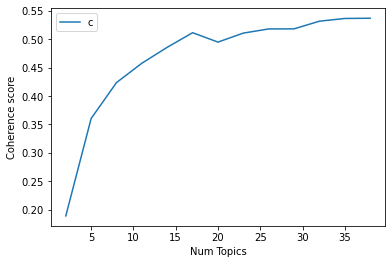

In [12]:
# Can take a long time to run.
limit=40; start=2; step=3;
model_list, coherence_values = loop_compute_coherence_values(id2word=id2word, corpus=corpus, texts=docs, mallet_path=mallet_path, start=start, limit=limit, step=step)

# Show graph
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [13]:
coherence_values

[0.1892453934546836,
 0.36050858882911546,
 0.4235994692881965,
 0.45762735295692103,
 0.4856239575281081,
 0.5112665876542648,
 0.4947429499680128,
 0.5105737364293761,
 0.5178710571664881,
 0.5180311842401603,
 0.5315036206338909,
 0.5362784248177126,
 0.5366768888311417]

In [39]:
topics = [
    ['case', 'state', 'rise', 'death', 'report', 'infection', 'confirm', 'maharashtra', 'numb', 'increase', 'total', 'coronavirusoutbreak', 'high', 'recovery', 'govt', 'surge', 'record', 'coronaviruspandemic', 'daily', 'breaking', 'positive', 'number', 'active_case', 'district', 'hour', 'spike', 'continue', 'death_toll', 'health_ministry', 'rate', 'fatality', 'live_update', 'low', 'additional', 'lakh', 'jump', 'total_numb', 'today', 'reach', 'discharge', 'fresh', 'mark', 'department_health', 'county', 'tally', 'include', 'bring_total', 'register', 'double', 'past_hour', 'newsalert', 'drop', 'climb', 'live_updates', 'soar', 'karnataka', 'recover', 'covidindia', 'record_high', 'relate_death', 'covidー', 'count', 'log', 'yesterday', 'fall', 'patient_recover', 'follow_live_update', 'worldwide', 'death_toll_rise', 'centre', 'hospitalization', 'doh', 'tamil_nadu', 'bring_total_numb', 'coronavirusupdates', 'peak', 'union_health_ministry', 'health_department', 'hit', 'additional_death', 'pune', 'trend', 'stand', 'telangana', 'country', 'punjab', 'toll', 'cases', 'infection_rate', 'bring', 'bihar', 'single_day', 'total_active', 'previous', 'high_daily', 'indiafightscorona', 'positivity_rate', 'filipino_abroad', 'rajasthan', 'top', 'victoria_record_new', 'coronavirusindia', 'exceed', 'ministry_health', 'mumbai', 'past_week', 'dfa', 'kerala', 'dip', 'cross', 'decrease', 'updates', 'reports', 'past_day', 'assam', 'consecutive_day', 'madhya_pradesh', 'milestone', 'recovery_rate', 'western_cape', 'pradesh', 'rapidly', 'follow_live_updates', 'overtake', 'coronavirusupdate', 'day', 'odisha', 'take_total_numb', 'west_bengal', 'high_single_day', 'seal', 'kashmir', 'kaduna', 'tally_rise', 'wrong_hit', 'uttarakhand', 'uttarpradesh', 'gujarat', 'tamilnadu'],
    ['pandemic', 'year', 'worker', 'amid', 'vaccination', 'plan', 'impact', 'work', 'crisis', 'business', 'government', 'hold', 'economy', 'community', 'deal', 'hit', 'group', 'fund', 'global', 'support', 'cancel', 'demand', 'offer', 'house', 'market', 'free', 'sign', 'company', 'launch', 'event', 'job', 'employee', 'relief', 'industry', 'provide', 'seek', 'half', 'service', 'ongoing', 'cost', 'food', 'postpone', 'cut', 'ensure', 'aid', 'expect', 'centre', 'push', 'cent', 'pay', 'budget', 'big', 'effort', 'pass', 'sector', 'affect', 'delay', 'boost', 'urge', 'money', 'sale', 'citizen', 'congress', 'price', 'target', 'concern', 'bank', 'include', 'bill', 'stock', 'cover', 'power', 'quarter', 'nstnation', 'spend', 'firm', 'poor', 'massive', 'sell', 'protect', 'season', 'trade', 'people', 'reuters', 'drive', 'host', 'percent', 'benefit', 'law', 'loss', 'vulnerable', 'light', 'fall', 'access', 'celebrate', 'growth', 'donate', 'set', 'financial', 'site', 'lawmaker', 'estimate', 'involve', 'propose', 'household', 'fight', 'party', 'struggle', 'office', 'senate', 'product', 'essential', 'package', 'loan', 'app', 'parliament', 'shock', 'initiative', 'unveil', 'bernama', 'relief_bill', 'revenue', 'social', 'small_business', 'gain', 'malaysian', 'supreme_court', 'economic_recovery', 'apply', 'annual', 'lose_job', 'location', 'farmer', 'debt', 'public', 'celebration', 'profit', 'sabah', 'relief_package', 'fallout', 'programme', 'festival', 'weigh', 'workplace', 'call', 'performance', 'scheme', 'session', 'oil', 'healthcare', 'proposal', 'month', 'donation', 'file', 'global_economy', 'plant', 'stimulus_package', 'economist', 'employer', 'judge', 'credit', 'assistance', 'inquiry', 'boom', 'mission', 'legal', 'job_loss', 'network', 'stall', 'world_bank', 'amazon', 'violence', 'pain', 'commit', 'owe', 'tool', 'registration', 'relief_fund', 'google', 'mco', 'vital', 'organisation'],
    ['school', 'home', 'close', 'amid', 'open', 'student', 'child', 'return', 'pandemic', 'force', 'leave', 'reopen', 'shut', 'online', 'send', 'stay', 'learn', 'safe', 'parent', 'kid', 'restaurant', 'scare', 'shutdown', 'university', 'miss', 'store', 'teacher', 'closure', 'education', 'summer', 'work_home', 'class', 'turn', 'bring', 'finally', 'virtual', 'option', 'migrant', 'work', 'space', 'owner', 'college', 'fee', 'teach', 'children', 'exam', 'reopen_school', 'safely', 'gym', 'eat', 'teen', 'pet', 'shelter', 'girl', 'meal', 'mom', 'parents', 'remain_open'],
    ['time', 'test_positive', 'world', 'news', 'pandemic', 'die', 'face', 'people', 'post', 'man', 'change', 'family', 'write', 'woman', 'life', 'contract', 'challenge', 'resident', 'share', 'year_old', 'make', 'person', 'opinion', 'breaking', 'experience', 'australian', 'thing', 'reveal', 'big', 'age', 'good', 'victoria', 'happen', 'nsw', 'wrong', 'victim', 'future', 'couple', 'long', 'kill', 'feel', 'infect', 'problem', 'diagnose', 'great', 'nurse_home', 'survive', 'wife', 'lot', 'visit', 'hope', 'isolation', 'play', 'hotel_quarantine', 'create', 'mother', 'cope', 'young', 'mental_health', 'jail', 'stress', 'prison', 'love', 'victorian', 'real', 'son', 'history', 'care_home', 'social_medium', 'cop', 'normal', 'test_negative', 'moment', 'complication', 'difficult', 'dozen', 'story', 'catch', 'film', 'daughter', 'bring', 'reportedly', 'opportunity', 'husband', 'reality', 'inmate', 'look_like', 'father', 'era', 'year_old_man', 'new_normal', 'mum', 'kind', 'baby', 'digital', 'leave', 'devastate', 'year_old_woman', 'decade', 'quarantine_hotel', 'music', 'home', 'bite', 'funeral', 'art', 'dad', 'overcome', 'pass_away', 'environment', 'sydney', 'perspective', 'relative', 'song'],
    ['response', 'update', 'live', 'trump', 'late', 'amp', 'american', 'official', 'watch', 'call', 'early', 'pm', 'emergency', 'give', 'meet', 'president', 'province', 'today', 'nation', 'release', 'situation', 'national', 'datum', 'video', 'lead', 'health_official', 'speak', 'team', 'accord', 'talk', 'claim', 'canadian', 'join', 'president_trump', 'month', 'question', 'crisis', 'watch_live', 'minister', 'declare', 'january', 'discuss', 'handle', 'news', 'fight', 'white_house', 'tuesday', 'health_minister', 'leader', 'expect', 'detail', 'expert', 'relate', 'listen', 'address', 'december', 'pm_modi', 'election', 'thursday', 'indian', 'analysis', 'senior', 'special', 'governor', 'september', 'govt', 'policy', 'week', 'explain', 'president_donald_trump', 'ottnews', 'review', 'task_force', 'february', 'tomorrow', 'action', 'track', 'tonight', 'approach', 'friday', 'union', 'donald_trump', 'public_health', 'india', 'administration', 'follow', 'answer', 'fail', 'federal', 'exclusive', 'respond', 'october', 'story', 'biden', 'source', 'mp', 'poll', 'vaccine_rollout', 'catch', 'pandemic', 'november', 'follow_update', 'accuse', 'wednesday', 'bjp', 'attack', 'africa', 'vmnews', 'slam', 'begin', 'interview', 'head', 'outbreak', 'tv', 'model', 'states', 'win', 'quebec', 'political', 'sabcnews', 'times', 'diagnosis', 'provide_update', 'grind', 'joe_biden', 'guidance', 'conversation', 'defend', 'publish', 'newsnight', 'debate', 'thread', 'discussion', 'comment', 'trudeau', 'tune', 'trump_administration', 'weekly', 'chair', 'twitter', 'commission', 'answer_question', 'trust', 'ontario', 'preparedness', 'dr_anthony_fauci', 'tracker', 'pm_narendra_modi', 'failure', 'provincial', 'warrior', 'leadership', 'chief_medical_officer', 'episode', 'defeat', 'covidab', 'dstv', 'praise', 'cdnpoli', 'coming', 'criticism', 'statistic', 'pres_trump', 'prime_minister_justin_trudeau', 'opposition', 'headline', 'voter', 'projection', 'speech', 'historic', 'government', 'climate_change'],
    ['day', 'order', 'lockdown', 'country', 'travel', 'restriction', 'read', 'start', 'quarantine', 'measure', 'disease', 'week', 'police', 'ease', 'city', 'issue', 'level', 'area', 'march', 'social_distance', 'place', 'sa', 'announce', 'follow', 'rule', 'list', 'april', 'guideline', 'impose', 'add', 'end', 'protocol', 'lift', 'ph', 'extend', 'mask', 'boris_johnson', 'filipino', 'begin', 'public', 'weekend', 'na', 'monday', 'suspend', 'curb', 'government', 'month', 'passenger', 'protest', 'ang', 'june', 'flight', 'strict', 'doh', 'july', 'wear_mask', 'christmas', 'ng', 'sunday', 'resume', 'anti', 'remain', 'nationwide', 'train', 'break', 'ncov', 'decide', 'check', 'curfew', 'roque', 'period', 'hotel', 'metro_manila', 'complete', 'relax', 'icymi', 'saturday', 'holiday', 'ahead', 'national', 'august', 'arrest', 'stage', 'duterte', 'set', 'require', 'tough', 'arrive', 'friday', 'urge', 'enforce', 'president_rodrigo_duterte', 'date', 'breach', 'street', 'monitor', 'extension', 'airport', 'limit', 'arrival', 'bengaluru', 'fine', 'plan', 'region', 'need_know', 'player', 'brit', 'quarantine_facility', 'tuesday', 'advice', 'crowd', 'enhance_community_quarantine', 'village', 'ban', 'johnson', 'affect', 'relaxation', 'airline', 'personnel', 'average', 'activity', 'decision', 'president_duterte', 'covidpandemic', 'violate', 'local_government', 'phase', 'authority', 'pub', 'abroad', 'goa', 'game', 'part', 'malacañang', 'photos', 'tourism', 'include', 'induce', 'mandatory', 'exercise', 'wednesday', 'chandigarh', 'fly', 'local', 'frontliners', 'ottnews_ottawa', 'church', 'tier', 'community_quarantine', 'haryana', 'fan', 'stay_home_order', 'duque', 'containment_zone', 'easter', 'covidquarantine', 'traveller', 'restriction_ease', 'travel_ban', 'chennai', 'prevent_spread', 'mall', 'galvez', 'quarantine_period', 'norm', 'tighten', 'philippine', 'mid', 'precaution', 'ease_restriction', 'recommendation', 'trip', 'slow_spread', 'wa', 'land', 'protester', 'cdntopstories', 'observe', 'confusion', 'pnp', 'club', 'briton', 'lgus', 'flout', 'alert_level', 'curve', 'driver', 'social_distance_measure', 'distance', 'exit', 'ofws', 'spot', 'enforcement', 'yung', 'guest', 'ncr', 'football', 'prime_minister_boris_johnson', 'presidential_spokesperson_harry_roque', 'station', 'mkhize', 'muslim', 'health_secretary_francisco', 'vaccine_passport', 'reiterate', 'match', 'compliance', 'comply'],
    ['patient', 'test', 'outbreak', 'hospital', 'people', 'spread', 'health', 'find', 'warn', 'doctor', 'study', 'virus', 'battle', 'variant', 'fear', 'treatment', 'result', 'wave', 'facility', 'symptom', 'vanguardnews', 'treat', 'risk', 'care', 'infect', 'chinese', 'medical', 'positive', 'europe', 'system', 'show', 'control', 'nurse', 'strain', 'malay_mail', 'staff', 'conduct', 'deadly', 'chief', 'detect', 'stop', 'fight', 'identify', 'nigerian', 'inside', 'research', 'grow', 'line', 'screen', 'cluster', 'build', 'lab', 'expert', 'cure', 'researcher', 'scientist', 'admit', 'carry', 'prevent', 'body', 'expose', 'concern', 'healthcare_worker', 'negative', 'worry', 'run', 'transmission', 'fg', 'condition', 'contact', 'fmtnews', 'lagos', 'evidence', 'world_health_organization', 'bed', 'wait', 'epidemic', 'shift', 'reduce', 'link', 'health_worker', 'population', 'thecable', 'suspect', 'country', 'work', 'human', 'emerge', 'fire', 'test_result', 'lock', 'officer', 'undergo', 'nstworld', 'recover', 'test_kit', 'global', 'critical', 'suggest', 'nigeria', 'ventilator', 'sample', 'panic', 'nhs', 'asymptomatic', 'ncdc', 'doctors', 'develop', 'quickly', 'sick', 'antibody', 'wrong', 'health_care_worker', 'icmr', 'buhari', 'icu', 'study_find', 'medicine', 'rapid', 'winter', 'ward', 'scientists', 'spark', 'describe', 'high_risk', 'lead', 'frontline', 'exposure', 'resurgence', 'private_hospital', 'trace', 'expert_warn', 'duty', 'close_contact', 'epicentre', 'commissioner', 'animal', 'new_youtube', 'army', 'long', 'origin', 'overwhelm', 'caution', 'oxygen', 'claim', 'china', 'save_live', 'mutation', 'danger', 'ppe', 'researchers', 'epicenter', 'intensive_care', 'study_show', 'ptf', 'hospitals', 'ability', 'palliative', 'aiims', 'infectious', 'gravitas', 'dedicate', 'rapid_test', 'scam', 'equipment', 'asian', 'transfer', 'fears'],
    ['vaccine', 'dose', 'receive', 'astrazeneca', 'trial', 'supply', 'ready', 'jab', 'shoot', 'approve', 'pfizer', 'roll', 'develope', 'effective', 'eu', 'development', 'vaccinate', 'shot', 'deliver', 'distribution', 'race', 'delivery', 'covidvaccine', 'administer', 'volunteer', 'produce', 'distribute', 'approval', 'johnson_amp_johnson', 'clinical_trial', 'rollout', 'vaccination', 'fda', 'moderna', 'manufacture', 'russian', 'potential', 'sinovac', 'pfizer_biontech', 'vaccine_candidate', 'give', 'manufacturer', 'experimental', 'shipment', 'covishield', 'procure']
]

In [43]:
ch2 = CoherenceModel(topics=topics, texts=docs, dictionary=dictionary, coherence='c_v')
cm2 = ch2.get_coherence()
ct2 = ch2.get_coherence_per_topic()

In [30]:
ch = CoherenceModel(model=ldamallet, texts=docs, dictionary=dictionary, coherence='c_v')
cm = ch.get_coherence()
ct = ch.get_coherence_per_topic()

In [37]:
ct

[0.5045240018586463,
 0.457429369616528,
 0.39920349346028877,
 0.632010435653083,
 0.5676439882354302,
 0.7761133997948086,
 0.4258232788488341,
 0.40830264158623547,
 0.45647835420339933,
 0.5317752172531746,
 0.5020692943267668,
 0.5413021154766547,
 0.5135971149032914,
 0.3908425767860518,
 0.49576224182692885,
 0.6483536339736877,
 0.5485482238894555,
 0.4492176147115874,
 0.5023008732303528,
 0.4343779247905027]

In [45]:
cm2

0.4176788044591231

In [44]:
ct2

[0.5459828234103381,
 0.3692984340037231,
 0.4957032362906711,
 0.3049389606300409,
 0.3250778286215447,
 0.3490729300288671,
 0.3126503754655304,
 0.6387058472222693]

# Train LDA

In [11]:
# Train model
temp_file = datapath("model2")
ldamallet = gensim.models.wrappers.LdaMallet.load(temp_file)
# ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=17, id2word=id2word, random_seed=50)
model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)

In [18]:
# Save the model
# temp_file = datapath("model2")
# ldamallet.save(temp_file)

In [15]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
16     0.340755  0.228194       1        1  5.959309
14     0.056720 -0.105384       2        1  5.929582
2     -0.014622 -0.013133       3        1  5.902262
5      0.326117  0.231772       4        1  5.899989
13     0.047276 -0.090997       5        1  5.897638
0     -0.210126  0.176295       6        1  5.892024
15     0.006356 -0.184034       7        1  5.886223
3     -0.233853  0.193284       8        1  5.884812
7     -0.070396 -0.073062       9        1  5.880564
12     0.014570 -0.102505      10        1  5.876393
8     -0.129372 -0.010585      11        1  5.869187
11    -0.245498  0.202522      12        1  5.868076
6     -0.014821 -0.086966      13        1  5.865909
1      0.094237 -0.082895      14        1  5.856141
9      0.016005 -0.098497      15        1  5.855743
10    -0.023141 -0.004438      16        1  5.852654
4      0.039793 -0.179571      17        1  5.823496, topic_info=         Term           Freq          Total Category  logprob  loglift
102      case  252197.000000  252197.000000  Default  30.0000  30.0000
3    lockdown  185531.000000  185531.000000  Default  29.0000  29.0000
16    vaccine  174668.000000  174668.000000  Default  28.0000  28.0000
193  pandemic  237717.000000  237717.000000  Default  27.0000  27.0000
28     report  106735.000000  106735.000000  Default  26.0000  26.0000
..        ...            ...            ...      ...      ...      ...
45     people   30800.851991   98752.713843  Topic17  -2.9282   1.6782
849    battle    7669.629263   13322.186778  Topic17  -4.3185   2.2911
332    infect    6694.256092   17790.117005  Topic17  -4.4545   1.8659
420       man    5850.034793   13843.967665  Topic17  -4.5893   1.9819
119        dr    4211.187443    5741.478398  Topic17  -4.9180   2.5333

[997 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
434       7  0.999857        accord
434      15  0.000141        accord
555       4  0.000272        accuse
555      11  0.999607        accuse
1742      1  0.999949   active_case
...     ...       ...           ...
831      16  1.000369           yeg
648      17  1.000095         young
1056      2  0.000932  young_people
1056     13  0.999159  young_people
1741     12  1.000124         youth

[1605 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[17, 15, 3, 6, 14, 1, 16, 4, 8, 13, 9, 12, 7, 2, 10, 11, 5])

In [19]:
CoherenceModel(model=ldamallet, texts=docs, dictionary=dictionary, coherence='c_v').get_coherence()

0.5112665876542648

In [47]:
m_coherence = CoherenceModel(model=ldamallet, texts=docs, dictionary=dictionary, coherence='c_v')

In [48]:
m_coherence_per_topic = m_coherence.get_coherence_per_topic()

In [82]:
np.round(np.array(m_coherence_per_topic) * 100,2)

array([54.61, 40.66, 50.16, 48.32, 53.52, 58.61, 44.34, 42.43, 47.99,
       50.37, 45.72, 47.48, 62.42, 52.98, 47.06, 45.64, 76.82])

In [54]:
df_iter = ldamallet.load_document_topics()
df = []
for k in df_iter:
    df.append([i[1] for i in k])
df = pd.DataFrame(df, columns=[fr'topic_{k}' for k in range(17)])
df['topic'] = df.idxmax(axis=1)
df['num_topic'] = df.topic.apply(lambda x: int(x.replace('topic_','')))

In [72]:
df['num_topic'] = df.topic.apply(lambda x: int(x.replace('topic_','')))

In [75]:
df.num_topic.value_counts(normalize=True).sort_index() * 100

0     11.152372
1      8.905642
2      7.522627
3      7.563384
4      8.647749
5      7.079537
6      5.517940
7      5.425401
8      5.042495
9      5.743894
10     4.245816
11     3.650839
12     6.023297
13     3.546860
14     2.494016
15     2.938059
16     4.500074
Name: num_topic, dtype: float64

In [85]:
df.shape

(1678217, 19)

In [87]:
df['tweetId'] = news_tweets.tweetId.values

In [88]:
df

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic,num_topic,tweetId
0,0.056561,0.056561,0.056561,0.056561,0.056561,0.056561,0.075792,0.056561,0.056561,0.056561,0.056561,0.056561,0.056561,0.056561,0.056561,0.075792,0.056561,topic_6,6,1.212177e+18
1,0.052521,0.052521,0.070378,0.070378,0.052521,0.052521,0.052521,0.070378,0.052521,0.070378,0.052521,0.052521,0.052521,0.052521,0.088235,0.052521,0.052521,topic_14,14,1.212188e+18
2,0.055494,0.055494,0.055494,0.055494,0.055494,0.055494,0.093230,0.055494,0.055494,0.055494,0.055494,0.055494,0.055494,0.055494,0.055494,0.074362,0.055494,topic_6,6,1.212193e+18
3,0.070378,0.052521,0.052521,0.052521,0.070378,0.052521,0.052521,0.070378,0.052521,0.052521,0.052521,0.052521,0.070378,0.052521,0.052521,0.088235,0.052521,topic_15,15,1.212478e+18
4,0.053476,0.053476,0.071658,0.053476,0.053476,0.053476,0.053476,0.053476,0.053476,0.053476,0.053476,0.053476,0.089840,0.071658,0.053476,0.071658,0.053476,topic_12,12,1.212520e+18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1678212,0.049020,0.049020,0.049020,0.049020,0.049020,0.065686,0.065686,0.049020,0.065686,0.065686,0.049020,0.049020,0.049020,0.099020,0.082353,0.065686,0.049020,topic_13,13,1.387918e+18
1678213,0.054466,0.054466,0.054466,0.054466,0.054466,0.091503,0.054466,0.072985,0.054466,0.054466,0.054466,0.054466,0.054466,0.054466,0.054466,0.054466,0.072985,topic_5,5,1.387918e+18
1678214,0.050710,0.050710,0.067951,0.154158,0.050710,0.050710,0.067951,0.050710,0.050710,0.050710,0.050710,0.050710,0.050710,0.050710,0.050710,0.050710,0.050710,topic_3,3,1.387919e+18
1678215,0.054466,0.054466,0.054466,0.054466,0.054466,0.072985,0.054466,0.054466,0.054466,0.054466,0.054466,0.072985,0.054466,0.054466,0.072985,0.072985,0.054466,topic_5,5,1.387919e+18


In [187]:
df.to_parquet('./../data/processed/news_tweets_topics_v4.parquet')

In [86]:
news_tweets.tweetId.values

array([1.21217688e+18, 1.21218750e+18, 1.21219314e+18, ...,
       1.38791864e+18, 1.38791925e+18, 1.38791926e+18])

In [156]:
df.num_topic[0] in themes

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [83]:
themes = [
    [16,5],
    [0,3,7],
    [11],
    [4],
    [1,8,13],
    [2,9,10,14],
    [6,15],
    [12]
]

In [157]:
topic2theme = pd.DataFrame({
    'topic':[fr'topic_{k}' for k in range(17)], 
    'theme':[2,5,6,2,4,1,7,2,5,6,6,3,8,5,6,7,1]
})

df = df.merge(topic2theme, how='left')

In [159]:
df.theme.value_counts()

2    405141
6    335750
5    293604
1    194331
4    145128
7    141910
8    101084
3     61269
Name: theme, dtype: int64

In [139]:
list(theme_words_tmp.drop_duplicates('wordid').wordid.values[:20])

['vaccine',
 'vaccination',
 'dose',
 'receive',
 'astrazeneca',
 'trial',
 'supply',
 'ready',
 'vaccinate',
 'jab',
 'shoot',
 'approve',
 'pfizer',
 'roll',
 'develope',
 'effective',
 'begin',
 'give',
 'eu',
 'phase']

In [142]:
themes_keywords = []
for theme in themes:
    theme_words_tmp = pd.DataFrame()
    for topic in theme:
        tmp = pd.DataFrame(model.get_topic_terms(topic,20), columns=['wordid','imp'])
        theme_words_tmp = pd.concat([theme_words_tmp, tmp])
    theme_words_tmp = theme_words_tmp.sort_values('imp', ascending=False)
    theme_words_tmp['wordid'] = theme_words_tmp.wordid.apply(lambda x: d[x])
    themes_keywords = themes_keywords + [list(theme_words_tmp.drop_duplicates('wordid').wordid.values[:20])]

In [144]:
ch2 = CoherenceModel(topics=themes_keywords, texts=docs, dictionary=dictionary, coherence='c_v')

In [146]:
cm = ch2.get_coherence()
ct = ch2.get_coherence_per_topic()

In [148]:
cm

0.4458135855491103

In [149]:
ct

[0.6084162328519914,
 0.3837689810147352,
 0.4560105330210148,
 0.5181523399730444,
 0.30296325559563825,
 0.31221385574574534,
 0.37408271619289024,
 0.6109007699978231]

In [39]:
vis.sorted_terms(1, 0.64).Term.values

array(['case', 'report', 'death', 'confirm', 'total', 'hour', 'recovery',
       'record', 'breaking', 'death_toll', 'fresh', 'active_case',
       'fatality', 'stand', 'additional', 'total_numb', 'tally',
       'health_ministry', 'department_health', 'discharge', 'covidph',
       'health_department', 'today', 'death_toll_rise', 'doh',
       'past_hour', 'bring_total', 'reach', 'relate_death',
       'ministry_health', 'patient_recover', 'bring_total_numb',
       'union_health_ministry', 'additional_death', 'take_total_numb',
       'include', 'total_active', 'sample_test', 'tally_rise', 'dfa',
       'patient_discharge', 'manage_isolation'], dtype=object)

In [122]:
model.get_term_topics(1)

[(6, 0.08518786635782674), (15, 0.02161607494103565)]

In [125]:
d = model.id2word

In [132]:
pd.DataFrame(model.get_topic_terms(0,20), columns=['wordid','imp'])

,wordid,imp
0,193,0.140760
1,48,0.063810
2,41,0.032095
3,395,0.031558
4,82,0.029744
5,239,0.029038
6,74,0.028859
7,350,0.028797
8,1076,0.028567
9,109,0.026795


In [23]:
pprint(model.print_topics())

[(0,
  '0.141*"pandemic" + 0.064*"world" + 0.032*"crisis" + 0.032*"face" + '
  '0.030*"hit" + 0.029*"global" + 0.029*"post" + 0.029*"impact" + '
  '0.029*"economy" + 0.027*"big"'),
 (1,
  '0.104*"news" + 0.077*"live" + 0.066*"update" + 0.051*"late" + '
  '0.048*"follow" + 0.044*"today" + 0.042*"watch" + 0.040*"pm" + '
  '0.028*"breaking" + 0.022*"give"'),
 (2,
  '0.081*"week" + 0.060*"month" + 0.055*"year" + 0.046*"start" + 0.037*"end" + '
  '0.032*"march" + 0.031*"day" + 0.031*"time" + 0.030*"begin" + '
  '0.029*"expect"'),
 (3,
  '0.092*"pandemic" + 0.040*"work" + 0.038*"amid" + 0.029*"worker" + '
  '0.028*"business" + 0.022*"company" + 0.019*"demand" + 0.018*"service" + '
  '0.018*"offer" + 0.015*"employee"'),
 (4,
  '0.095*"test_positive" + 0.084*"patient" + 0.068*"hospital" + 0.059*"die" + '
  '0.053*"people" + 0.033*"doctor" + 0.023*"staff" + 0.022*"person" + '
  '0.020*"contract" + 0.019*"treatment"'),
 (5,
  '0.173*"case" + 0.066*"infection" + 0.064*"rise" + 0.050*"numb" + '
  

In [150]:
subthemes = [
    (1,11,['rise', 'increase', 'high', 'spike', 'jump', 'reach', 'double', 'climb', 'soar', 'record_high', 'death_toll_rise', 'peak', 'hit', 'high_daily', 'top', 'exceed', 'high_single_day', 'tally_rise']),
    (1,12,['low', 'drop', 'fall', 'dip', 'decrease']),
    (2,21,['worker', 'plan', 'work', 'support', 'free', 'job', 'employee', 'food', 'citizen', 'congress', 'poor', 'protect', 'people', 'vulnerable', 'household', 'essential', 'loan', 'small_business', 'lose_job', 'donation', 'employer', 'assistance', 'job_loss']),
    (2,22,['impact', 'business', 'government', 'economy', 'global', 'demand', 'market', 'company', 'industry', 'cut', 'aid', 'budget', 'sector', 'boost', 'bank', 'bill', 'stock', 'quarter', 'trade', 'law', 'growth', 'lawmaker', 'office', 'relief_bill', 'supreme_court', 'economic_recovery', 'debt', 'profit', 'relief_package', 'global_economy', 'stimulus_package', 'world_bank', 'relief_fund', 'organisation']),
    (4,41,['nurse_home', 'care_home']),
    (4,42,['mental_health']),
    (4,43,['jail', 'prison', 'cop', 'inmate']),
    (4,44,['family', 'couple', 'wife', 'mother', 'son', 'daughter', 'husband', 'father', 'mum', 'baby', 'dad']),
    (5,51,['health_official', 'health_minister', 'expert', 'task_force', 'public_health', 'dr_anthony_fauci', 'chief_medical_officer']),
    (5,52,['trump', 'pm', 'president', 'president_trump', 'minister', 'white_house', 'leader', 'pm_modi', 'governor', 'govt', 'president_donald_trump', 'donald_trump', 'administration', 'federal', 'biden', 'mp', 'joe_biden', 'trudeau', 'trump_administration', 'pm_narendra_modi', 'leadership', 'pres_trump', 'prime_minister_justin_trudeau', 'opposition', 'government']),
    (5,53,['election', 'poll', 'debate', 'voter']),
    (6,61,['lockdown', 'restriction', 'quarantine', 'police', 'rule', 'impose', 'protocol', 'quarantine_facility', 'mandatory', 'community_quarantine', 'stay_home_order', 'containment_zone', 'covidquarantine', 'quarantine_period']),
    (6,62,['travel', 'passenger', 'flight', 'airport', 'plan', 'airline', 'tourism', 'fly', 'traveller', 'travel_ban', 'trip', 'vaccine_passport']),
    (6,63,['protest', 'anti', 'break', 'arrest', 'fine', 'protester']),
    (6,64,['social_distance', 'mask', 'wear_mask', 'social_distance_measure']),
    (6,65,['christmas', 'holiday', 'easter']),
    (6,66,['ease', 'relax', 'restriction_ease', 'ease_restriction', 'slow_spread']),
    (7,71,['outbreak', 'fear', 'chinese', 'detect', 'epidemic', 'suspect', 'emerge', 'panic', 'epicentre', 'animal', 'origin', 'china', 'epicenter']),
    (7,72,['hospital', 'study', 'treatment', 'research', 'lab', 'expert', 'cure', 'researcher', 'scientist', 'ventilator', 'study_find', 'medicine', 'scientists', 'private_hospital', 'expert_warn', 'oxygen', 'researchers', 'intensive_care', 'study_show', 'hospitals', 'palliative']),
    (7,73,['variant', 'wave', 'strain', 'mutation']),
    (7,74,['doctor', 'medical', 'healthcare_worker', 'health_worker', 'doctors', 'health_care_worker'])
]

In [183]:
list(dictionary.values)

TypeError: 'method' object is not iterable

In [151]:
for col in [fr'subtheme{subtheme[1]}' for subtheme in subthemes]:
    df[col] = False

In [166]:
with open("data_pp.pickle", "rb") as fp:   # Unpickling
    b = pickle.load(fp)

In [174]:
for k in range(1,9):
    subthemes_desc = [subtheme for subtheme in subthemes if subtheme[0]==k]
    if len(subthemes_desc)>0:
        indices = list(df[df.theme==k].index)
        topic_docs = [docs[i] for i in indices]
        for subtheme_desc in subthemes_desc:
            kw = subtheme_desc[2]
            t = [ind for k, ind in enumerate(indices) if any(i in topic_docs[k] for i in kw)]
            df.loc[t,fr'subtheme{subtheme_desc[1]}'] = True

In [186]:
df[[fr'subtheme{subtheme[1]}' for subtheme in subthemes]].sum()

subtheme11     64646
subtheme12     10765
subtheme21     77813
subtheme22    113288
subtheme41      1934
subtheme42        69
subtheme43      2853
subtheme44      7484
subtheme51     12490
subtheme52     65979
subtheme53      5696
subtheme61    129126
subtheme62     20217
subtheme63     12968
subtheme64      5497
subtheme65      4768
subtheme66     10283
subtheme71     31887
subtheme72     23894
subtheme73     13831
subtheme74      2089
dtype: int64

In [188]:
themes_keywords2 = []
for theme in themes:
    theme_words_tmp = pd.DataFrame()
    for topic in theme:
        tmp = pd.DataFrame(model.get_topic_terms(topic,50), columns=['wordid','imp'])
        theme_words_tmp = pd.concat([theme_words_tmp, tmp])
    theme_words_tmp = theme_words_tmp.sort_values('imp', ascending=False)
    theme_words_tmp['wordid'] = theme_words_tmp.wordid.apply(lambda x: d[x])
    themes_keywords2 = themes_keywords2 + [list(theme_words_tmp.drop_duplicates('wordid').wordid.values[:50])]

In [195]:
themes_keywords2[3]

['test_positive',
 'patient',
 'hospital',
 'die',
 'people',
 'doctor',
 'staff',
 'person',
 'contract',
 'treatment',
 'recover',
 'treat',
 'year_old',
 'battle',
 'facility',
 'care',
 'symptom',
 'medical',
 'infect',
 'nurse',
 'test_negative',
 'man',
 'suspect',
 'health_worker',
 'victim',
 'dr',
 'admit',
 'body',
 'dead',
 'contact',
 'nurse_home',
 'diagnose',
 'fire',
 'wife',
 'condition',
 'young',
 'bed',
 'attend',
 'recently',
 'ventilator',
 'doctors',
 'age',
 'healthcare_worker',
 'nhs',
 'prison',
 'self_isolate',
 'sick',
 'shift',
 'self_quarantine',
 'isolation']

In [54]:
df_iter = ldamallet.load_document_topics()
df = []
for k in df_iter:
    df.append([i[1] for i in k])
df = pd.DataFrame(df, columns=[fr'topic_{k}' for k in range(20)])

In [56]:
df['topic'] = df.idxmax(axis=1)
df

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic
0,0.041667,0.041667,0.058333,0.058333,0.058333,0.041667,0.041667,0.058333,0.058333,0.058333,0.041667,0.041667,0.058333,0.075000,0.041667,0.058333,0.041667,0.041667,0.041667,0.041667,topic_13
1,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.064815,0.046296,0.046296,0.083333,0.046296,0.064815,0.046296,0.046296,0.046296,topic_14
2,0.044643,0.080357,0.044643,0.044643,0.044643,0.044643,0.044643,0.062500,0.044643,0.044643,0.044643,0.044643,0.080357,0.044643,0.044643,0.044643,0.062500,0.044643,0.044643,0.044643,topic_1
3,0.101562,0.070312,0.039062,0.039062,0.039062,0.039062,0.054688,0.039062,0.132812,0.039062,0.039062,0.039062,0.039062,0.039062,0.039062,0.039062,0.039062,0.054688,0.039062,0.039062,topic_8
4,0.046296,0.064815,0.046296,0.046296,0.046296,0.046296,0.046296,0.064815,0.046296,0.046296,0.046296,0.064815,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.064815,0.046296,topic_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1814501,0.048077,0.048077,0.048077,0.048077,0.048077,0.048077,0.048077,0.048077,0.067308,0.048077,0.048077,0.048077,0.048077,0.067308,0.048077,0.048077,0.048077,0.048077,0.048077,0.048077,topic_8
1814502,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.120370,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,topic_11
1814503,0.044643,0.044643,0.080357,0.044643,0.062500,0.044643,0.062500,0.062500,0.044643,0.062500,0.044643,0.044643,0.044643,0.044643,0.044643,0.044643,0.044643,0.044643,0.044643,0.044643,topic_2
1814504,0.046296,0.046296,0.046296,0.046296,0.083333,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.064815,0.046296,0.046296,0.046296,0.046296,0.064815,topic_4


In [87]:
df_iter = ldamallet.load_document_topics()
df = []
for k in df_iter:
    df.append([i[1] for i in k])
df = pd.DataFrame(df, columns=[fr'topic_{k}' for k in range(20)])
df['topic'] = df.idxmax(axis=1)

In [62]:
topic2theme = pd.DataFrame({
    'topic':[fr'topic_{k}' for k in range(20)], 
    'theme':[7,3,2,1,2,1,2,5,7,6,6,6,5,7,5,8,1,4,4,6]
})

df = df.merge(topic2theme, how='left')

In [65]:
for col in [fr'subtheme{subtheme[1]}' for subtheme in subthemes]:
    df[col] = False

In [68]:
for k in range(1,9):
    subthemes_desc = [subtheme for subtheme in subthemes if subtheme[0]==k]
    if len(subthemes_desc)>0:
        indices = list(df[df.theme==k].index)
        topic_docs = [b[0][i] for i in indices]
        for subtheme_desc in subthemes_desc:
            kw = subtheme_desc[2]
            t = [ind for k, ind in enumerate(indices) if any(i in topic_docs[k] for i in kw)]
            df.loc[t,fr'subtheme{subtheme_desc[1]}'] = True

In [70]:
tweets.tweetId.values

array([1331811812828803073, 1237432142214258688, 1234744569268338689, ...,
       1310723512223625216, 1266240991133970438, 1325600258848600065],
      dtype=int64)

In [71]:
df['tweetId'] = tweets.tweetId.values

In [73]:
df[[fr'topic_{k}' for k in range(20)]].max(axis=1).max()

0.2681159420289854

In [77]:
df.to_parquet('news_tweets_topics2.parquet', compression='gzip', index=False)

In [186]:
df.shape[0]

1814506

In [76]:
df

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic,theme,subtheme11,subtheme12,subtheme21,subtheme22,subtheme41,subtheme42,subtheme43,subtheme44,subtheme51,subtheme52,subtheme53,subtheme61,subtheme62,subtheme63,subtheme64,subtheme65,subtheme66,subtheme71,subtheme72,subtheme73,subtheme74,tweetId
0,0.041667,0.041667,0.058333,0.058333,0.058333,0.041667,0.041667,0.058333,0.058333,0.058333,0.041667,0.041667,0.058333,0.075000,0.041667,0.058333,0.041667,0.041667,0.041667,0.041667,topic_13,7,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1331811812828803073
1,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.064815,0.046296,0.046296,0.083333,0.046296,0.064815,0.046296,0.046296,0.046296,topic_14,5,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,1237432142214258688
2,0.044643,0.080357,0.044643,0.044643,0.044643,0.044643,0.044643,0.062500,0.044643,0.044643,0.044643,0.044643,0.080357,0.044643,0.044643,0.044643,0.062500,0.044643,0.044643,0.044643,topic_1,3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1234744569268338689
3,0.101562,0.070312,0.039062,0.039062,0.039062,0.039062,0.054688,0.039062,0.132812,0.039062,0.039062,0.039062,0.039062,0.039062,0.039062,0.039062,0.039062,0.054688,0.039062,0.039062,topic_8,7,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1290590799000793090
4,0.046296,0.064815,0.046296,0.046296,0.046296,0.046296,0.046296,0.064815,0.046296,0.046296,0.046296,0.064815,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.064815,0.046296,topic_1,3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1381989345708679172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1814501,0.048077,0.048077,0.048077,0.048077,0.048077,0.048077,0.048077,0.048077,0.067308,0.048077,0.048077,0.048077,0.048077,0.067308,0.048077,0.048077,0.048077,0.048077,0.048077,0.048077,topic_8,7,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1338677309054709761
1814502,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.120370,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,topic_11,6,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,1346192468350541829
1814503,0.044643,0.044643,0.080357,0.044643,0.062500,0.044643,0.062500,0.062500,0.044643,0.062500,0.044643,0.044643,0.044643,0.044643,0.044643,0.044643,0.044643,0.044643,0.044643,0.044643,topic_2,2,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1310723512223625216
1814504,0.046296,0.046296,0.046296,0.046296,0.083333,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.064815,0.046296,0.046296,0.046296,0.046296,0.064815,topic_4,2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1266240991133970438


In [185]:
df[[fr'subtheme{subtheme[1]}' for subtheme in subthemes]].sum(axis=0)

subtheme11    24882
subtheme12     4687
subtheme21    44784
subtheme22    41271
subtheme41      356
subtheme42      178
subtheme43      466
subtheme44     2045
subtheme51     5507
subtheme52    21703
subtheme53     1287
subtheme61    42059
subtheme62    10884
subtheme63     3971
subtheme64     3849
subtheme65     1651
subtheme66     2890
subtheme71    20791
subtheme72    20940
subtheme73     6134
subtheme74     6820
dtype: int64

In [181]:
df.topic.value_counts()

topic_0     175491
topic_1     160666
topic_2     140509
topic_3     135791
topic_5     119667
topic_4     115319
topic_15     95432
topic_6      94345
topic_8      90977
topic_10     84361
topic_7      79566
topic_11     75052
topic_9      70405
topic_12     63129
topic_13     61638
topic_14     60010
topic_17     56182
topic_16     48950
topic_18     46101
topic_19     40915
Name: topic, dtype: int64

In [165]:
tweets[tweets.tweetId.isin(df[df.subtheme73].tweetId.values)].sample(25).content.values

array(['Some of Melbourne’s biggest hospitals are bracing themselves for a huge surge of COVID-19 cases in coming days. \n\nThis is how the second wave crisis has unfolded in hospitals. https://t.co/aeSah0MkPV',
       'What we know about COVID vaccine effectiveness against the new variants https://t.co/Su7gSgMVQw',
       'Second waves of the pandemic have occurred around the world, sparking fears that Australia could be next. But experts say it’s avoidable.\n\nhttps://t.co/xz27TIOakS',
       "Japan detects new mutant 'vaccine-busting' Covid variant from traveller coming from Philippines https://t.co/1X8tTlXpQ5",
       'A leading medical professor claims lifting restrictions on air travel could cause a second wave of Covid-19 cases.\n\nhttps://t.co/dHTERBP8zf',
       'Wuhan to test all 11 million residents after the #COVID19 epicentre in China witnesses a second wave of coronavirus infection. @SinghBhairavi has more https://t.co/idQMokjJUL',
       'Health officials are calling on 

In [ ]:
# Train model
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word, random_seed=50)
model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)
temp_file = datapath("model")
ldamallet.save(temp_file)

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(model, corpus, dictionary)
vis

In [ ]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=docs, dictionary=dictionary, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

In [ ]:
# Train model
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)
model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(model, corpus, dictionary)
vis

In [ ]:
pprint(model.print_topics())
doc_lda = model[corpus]

In [ ]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=docs, dictionary=dictionary, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

In [ ]:
1

In [ ]:
ldamallet[corpus[10]]

In [ ]:
# Compute tweets topics
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamallet, corpus=corpus, texts=list(tweets.content))

# Format
df = df_topic_sents_keywords.reset_index()
df.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df.to_csv('tweets_topics2.csv')

# Show
df.head(5)

In [ ]:
df = pd.read_csv('tweets_topics2.csv')

In [ ]:
df[df.Topic_Perc_Contrib==0.05]

In [ ]:
indices = list(df_dominant_topic[df_dominant_topic.Dominant_Topic==2.0].Document_No)
topic_docs = [docs[i] for i in indices]

kw = ['low', 'fall', 'drop', 'decline']
t = [ind for k, ind in enumerate(indices) if any(i in topic_docs[k] for i in kw)]
len(t)

In [ ]:
(df.Dominant_Topic.value_counts() / df.shape[0]).sort_index()

In [ ]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(10)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]
sent_topics_sorteddf_mallet.to_csv('relevant_topics2.csv', sep="|")

In [ ]:
sent_topics_sorteddf_mallet[sent_topics_sorteddf_mallet.Topic_Num==19.0].Text.values

In [ ]:
topic_desc = pd.read_csv('topic_desc.csv', sep=';')

In [ ]:
# required: tweets, df, docs
tweets['theme'] = np.nan
for topic in topic_desc.topic.unique():
    topic_themes = topic_desc[topic_desc.topic==topic]
    non_default = []
    for index, row in topic_themes[topic_themes.default=='F'].iterrows():
        kw = row.keywords.replace(' ', '').split(',')
        t = [k for k in df[df.Dominant_Topic==topic].Document_No.values if any(i in kw for i in docs[k])]
        tweets.loc[t, 'theme'] = row.theme_id
        non_default = non_default + t
    topic_tweets = [k for k in df[df.Dominant_Topic==topic].Document_No.values]
    topic_tweets = np.setdiff1d(topic_tweets,non_default)
    tweets.loc[topic_tweets, 'theme'] = topic_themes[topic_themes.default=='T'].theme_id.unique()[0]

In [ ]:
topic_themes.themes.unique()[0]

In [ ]:
topic = 11
topic_themes = topic_desc[topic_desc.topic==topic]
non_default = []

In [ ]:
topic_themes

In [ ]:
topic_desc

In [ ]:
topic = 10
topic_desc[topic_desc.topic==topic]

In [ ]:
topic = 1
topic_themes = topic_desc[topic_desc.topic==topic]
non_default = []
for index, row in topic_themes[topic_themes.default=='F'].iterrows():
    kw = row.keywords.replace(' ', '').split(',')
    t = [k for k in df[df.Dominant_Topic==topic].Document_No.values if any(i in kw for i in docs[k])]
    print(row.themes, len(t))

In [ ]:
topic = 1
for topic in topic_desc.topic.unique():
    topic_themes = topic_desc[topic_desc.topic==topic]
    non_default = []
    for index, row in topic_themes[topic_themes.default=='F'].iterrows():
        kw = row.keywords.replace(' ', '').split(',')
        t = [k for k in df[df.Dominant_Topic==topic].Document_No.values if any(i in kw for i in docs[k])]
        print(row.themes, len(t))

In [ ]:
tweets[tweets.theme=='Elections'].content[:10].values

In [ ]:
tweets[['tweetId', 'theme']].to_parquet('news_tweets_topics.parquet', compression='gzip', index=False)

In [ ]:
tweets.theme.value_counts() / tweets.shape[0]

In [ ]:
topic_desc.topic.unique()

In [ ]:
tweets.theme.isnull().sum()

In [ ]:
topic_desc.keywords[20]

In [ ]:
docs[92]

In [ ]:
tweets[tweets.theme=='People violating mobility restrictions or protesting against them'].sample(frac=1).head(10).content.values

In [ ]:
(tweets.theme.nunique())

In [ ]:
df[df.Dominant_Topic==3.0]